In [74]:
from scratch.logistic_regression import tuples
from matplotlib import pyplot as plt

data = tuples
xs = [[1.0] + list(row[:2]) for row in data]
ys = [row[2] for row in data]

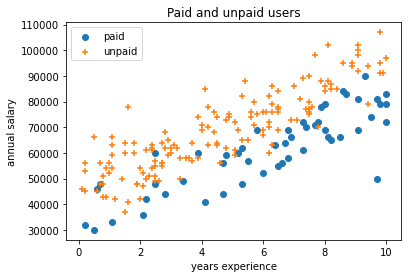

In [75]:
# salary vs years experience vs paid / unpaid users
plt.scatter([row[1]
            for row, y in zip(xs, ys)
            if y],
            [row[2]
            for row, y in zip(xs, ys)
            if y], label='paid')
plt.scatter([row[1]
            for row, y in zip(xs, ys)
            if not y],
            [row[2]
            for row, y in zip(xs, ys)
            if not y],
            marker='+', label='unpaid');
plt.title('Paid and unpaid users')
plt.xlabel('years experience')
plt.ylabel('annual salary')
plt.legend();

In [76]:
# lets model the problem as a linear regression 
# can we predict who is a paid user in the form paid = B * X ?
# we can model it for sure!

from scratch.working_with_data import rescale
from scratch.multiple_regression import least_squares_fit, predict
from scratch.gradient_descent import gradient_step
import math

In [77]:
learning_rate = 0.001
rescaled_xs = rescale(xs)

least squares fit: 100%|██████████| 1000/1000 [00:02<00:00, 473.86it/s]


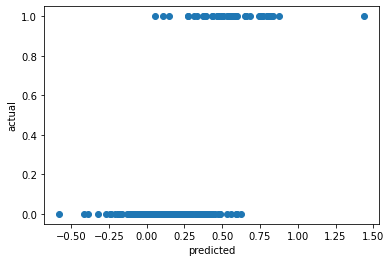

In [78]:
# issues with negative or over 1 values of predicted
# biased values for large experience values, larger error
beta = least_squares_fit(rescaled_xs, ys, learning_rate, 1000, 1)
predictions = [predict(xi, beta) for xi in rescaled_xs]
plt.scatter(predictions, ys)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [79]:
# lets create a link function

def logistic(x: float)->float:
    return 1.0 / (1 + math.exp(-x))

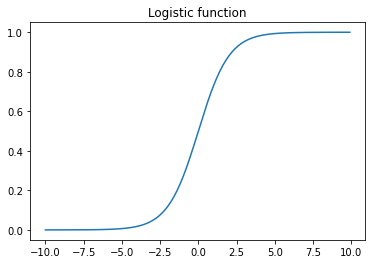

In [80]:
xs2 = [xi / 10 for xi in range(-100, 100)]
ys2 = [logistic(xi) for xi in xs2]
plt.plot(xs2, ys2)
plt.title('Logistic function');

In [81]:
# as the input gets lower --> output approx 0
# as the input gets higher --> output approx 1

# th elogistic fn also as a convineint derivative
def logistic_prime(x: float) ->float:
    y = logistic(x)
    return y * (1 - y)

# we'll use it to fit the model:
# y = fn(X * B) + err
# where f is the logistic fn

# in least squares min the sum squared err and maximizing likelihood of data is the same
# in log regression this is not the case so 
# we'll use the gradient that maximizes the likelihood directly

# the pdf for yi can be written
# p(y| xi, B) = fn(xi * B)** yi * (1 - fn(xi * B)) ** (1 - yi)
# turns out it's easier to maximize the log likelihood
# log L(B|xi, yi) = yi * log(fn(xi * B)) + (1 - yi) * log(1 - fn(xi * B))
# because log is strictly increasin, any beta that maximizes the log also 
# maximizes the likelihood

from scratch.linear_algebra import Vector, dot

# grad descent minimizes, 
# so we will maximize the negative log likelihood
def _negative_log_likelihood(x: Vector, y:float, beta:Vector) -> float:
    """
    The negative log likelihood for one data point
    """
    if y == 1:
        return -math.log(logistic(dot(x,beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))

# as we assume data points are independent in this model
# overall likelihood is the product of individual likelihoods
# in log terms that means we can sum the likelihoods

def negative_log_likelihood(xs: list[Vector],
                            ys: list[float],
                            beta: Vector) -> float:
    return sum(_negative_log_likelihood(xi, yi, beta)
               for xi, yi in zip(xs, ys))

# now for the gradient

from scratch.linear_algebra import vector_sum

def _negative_log_partial(x: Vector, y: float,
                          beta: Vector, j:int) -> float:
    """
    The jth partial derivative for one data point
    ith is the index of the data point
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x: Vector, y: float,
                           beta: Vector)-> Vector:
    """
    The Gradient for one data point
    """
    return [_negative_log_partial(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs: list[Vector],
                          ys: list[float],
                          beta: Vector)-> Vector:
    return vector_sum([_negative_log_gradient(xi, yi, beta)
                       for xi, yi in zip(xs, ys)])

# applying the model

from scratch.machine_learning import train_test_split
import random
import tqdm

random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)


In [85]:
learning_rate = 0.01

# random starting point for beta
beta = [random.random() for _ in rescaled_xs[0]]
with tqdm.trange(5_000) as t:
    for epoch in t:
        gradient = negative_log_gradient(x_train, y_train, beta)
        beta = gradient_step(beta, gradient, -learning_rate)
        loss = negative_log_likelihood(x_train, y_train, beta)
        t.set_description(f"loss: {loss:.3f} beta: {beta}")

loss: 39.963 beta: [-2.0239032476251424, 4.693047853942649, -4.469811321910748]: 100%|██████████| 5000/5000 [00:20<00:00, 248.66it/s]  


In [90]:
# these are the coef for the rescaled data
# lets convert them back to original scale

from scratch.working_with_data import scale

means, std = scale(xs)
beta_0 = (beta[0] - beta[1] * means[1] / std[1]) - (beta[2] * means[2] / std[2])
beta_unscaled = [beta_0,
                 beta[1] / std[1],
                 beta[2] / std[2]]
beta_unscaled

# not as easy to interpret as liner regression
# all else being equal an extra year of experience
# adds 1.6 to the input of logistic fn

#the impact on the output also depends on the other inputs as well
# if dot(beta, x_i) is already large/ small increasing bi a lot or little will
# not affectc the outcome of the probability

# all else being equal - people with more experience
# are more likly to pay for accounts
# and people of larger salary less likely 
# to pay for accounts

[8.927236932527311, 1.6482026277676038, -0.00028768900920142336]

In [95]:
# Goodness of Fit
# ie how good is this model

tp = fp = tn = fn = 0

# nice implicit control flow
for xi, yi in zip(x_test, y_test):
    prediction = logistic(dot(beta, xi))
    if yi == 1 and prediction >= .5:
        tp += 1
    elif yi == 1:
        fn += 1
    elif prediction >= .5:
        fp += 1
    else:
        tn += 1
        
precision = tp / (tp + fp)
recall = tp / (tp + fn)
precision, recall

(0.75, 0.8)

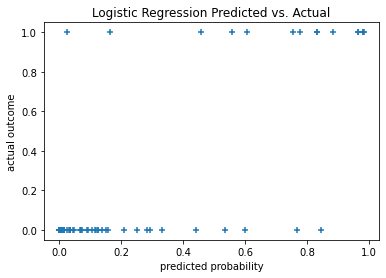

In [106]:
predictions = [logistic(dot(beta, xi)) 
                        for xi in x_test]
plt.scatter(predictions, y_test, marker='+')
plt.title('Logistic Regression Predicted vs. Actual')
plt.xlabel('predicted probability')
plt.ylabel('actual outcome');